In [1]:
import os

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from scipy import ndimage

from utils.yolo import get_teeth_ROI
from utils.edge import integral_intensity_projection, vertical_line_drawing, get_rotation_angle
from utils.edge import gum_jaw_separation, get_slope, window_avg, get_valley_window
from scipy.signal import find_peaks
from dotenv import load_dotenv

from glob import glob
from pathlib import Path

matplotlib.use('module://matplotlib_inline.backend_inline')
% matplotlib inline

load_dotenv()



True

In [2]:
data_dir = '..' / Path(os.getenv('DATASET_DIR'))


In [3]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')


YOLOv5  torch 1.12.0 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)



requirements: D:\Users\douli\anaconda3\envs\dentist-CV-main\Lib\site-packages\yolov5\requirements.txt not found, check failed.


Fusing layers... 
Model summary: 270 layers, 7041205 parameters, 0 gradients
Adding AutoShape... 


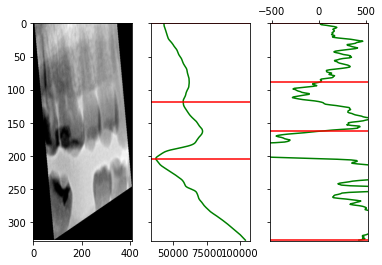

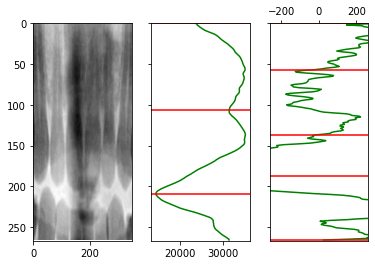

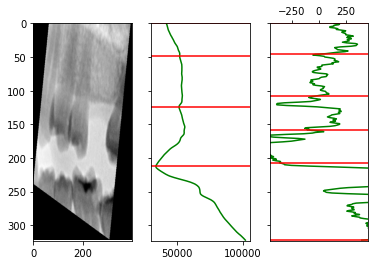

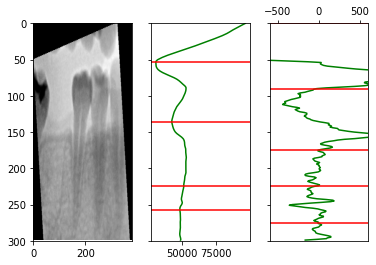

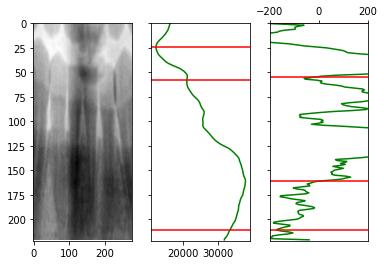

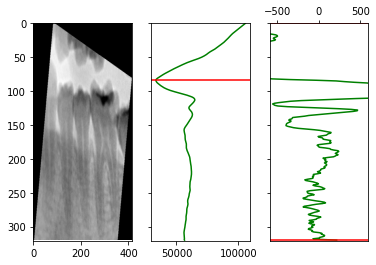

In [4]:
image_names = list(data_dir.glob('*008225.jpg'))
image_number = 1

filepath_image = image_names[0]
filename = filepath_image.stem

# Inference
results = model(filepath_image)

teeth_roi = get_teeth_ROI(results)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']

for teeth_roi_image in teeth_roi_images:
    flag = teeth_roi_image['flag']
    tooth_position = teeth_roi_image['tooth_position']
    source = cv.cvtColor(teeth_roi_image['image'], cv.COLOR_RGB2GRAY)

    margin = 30
    padding = 100

    theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
    source = ndimage.rotate(source, theta, reshape=True, cval=255)

    if flag == 'upper':
        source = source[padding:, :]
    elif flag == 'lower':
        source = source[:-padding, :]

    hor, _ = integral_intensity_projection(source)
    hor = window_avg(hor)
    hor_slope = get_slope(hor)
    window_position, window_size, hor_valleys = get_valley_window(hor_slope, hor, window_size_0=50, left_margin_0=30)

    jaw_sep_line = hor_valleys[hor[hor_valleys].argmin()]
    try:
        if flag == 'upper':
            # FIXME IndexError: index -1 is out of bounds for axis 0 with size 0
            gum_sep_line = hor_valleys[hor_valleys < jaw_sep_line - 30][-1]
            gum_sep_line -= margin
        elif flag == 'lower':
            gum_sep_line = hor_valleys[hor_valleys > jaw_sep_line + 30][0]
            gum_sep_line += margin
        else:
            raise ValueError(f'flag only accept upper or lower but get {flag}.')
    except IndexError:
        # didn't get gum_sep_line in hor_valleys
        gum_sep_line = jaw_sep_line - 100 - margin if flag == 'upper' else jaw_sep_line + 100 + margin

    # Plot
    height, width = source.shape
    index = np.array(range(height))

    fig, axs = plt.subplots(1, 3, sharey='all')
    # row i col 0
    # image = vertical_line_drawing(image, *window_position, color=0)
    axs[0].imshow(1 - source, aspect='auto', cmap='gray')
    # for v in valleys:
    #     axs[i][1].axhline(y=v, color='r')

    # row i col 1
    axs[1].plot(hor, index, 'g')
    # axs[i][1].xaxis.tick_top()
    axs[1].set_ylim(height, 0)
    for v in hor_valleys:
        axs[1].axhline(y=v, color='r')

    # row i col 2
    axs[2].plot(hor_slope, index, 'g')
    axs[2].xaxis.tick_top()
    axs[2].set_ylim(height, 0)
    axs[2].set_xlim(-hor_slope.std(), hor_slope.std())
    for v in window_position:
        axs[2].axhline(y=v, color='r')

    plt.show()



In [5]:
teeth_roi_image

{'flag': 'lower',
 'number': 2,
 'tooth_position': 'right',
 'org_file_name': '00008225',
 'offset': array([1291,  630]),
 'image': array([[[ 84,  84,  84],
         [ 84,  84,  84],
         [ 84,  84,  84],
         ...,
         [ 67,  67,  67],
         [ 59,  59,  59],
         [ 63,  63,  63]],
 
        [[ 83,  83,  83],
         [ 84,  84,  84],
         [ 84,  84,  84],
         ...,
         [ 59,  59,  59],
         [ 50,  50,  50],
         [ 54,  54,  54]],
 
        [[ 82,  82,  82],
         [ 84,  84,  84],
         [ 84,  84,  84],
         ...,
         [ 60,  60,  60],
         [ 50,  50,  50],
         [ 54,  54,  54]],
 
        ...,
 
        [[103, 103, 103],
         [103, 103, 103],
         [104, 104, 104],
         ...,
         [111, 111, 111],
         [103, 103, 103],
         [101, 101, 101]],
 
        [[100, 100, 100],
         [101, 101, 101],
         [106, 106, 106],
         ...,
         [106, 106, 106],
         [107, 107, 107],
         [107, 107

[84]
[167 168 179 181 182 220 237 276 277 285 287 309 317]


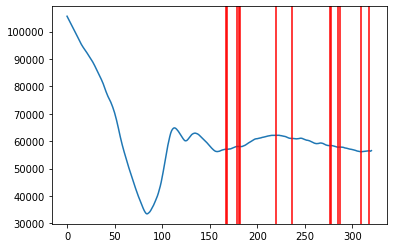

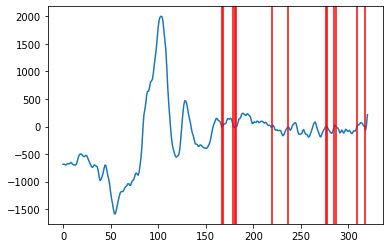

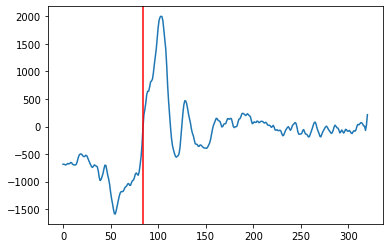

In [6]:
x = np.array(range(0, hor.shape[0]))

dy = np.gradient(hor)
dx = np.gradient(x)
d = np.gradient(hor, x)

# a = d[hor_valleys]

zero_points = np.where(abs(d) < 10)[0]

print(hor_valleys)
print(zero_points)

plt.plot(hor)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(d)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(hor_slope)
for i in hor_valleys:
    plt.axvline(x=i, color='r')
plt.show()
